# HSI Research and ETF Trading

## Continuation of nanodegree project and refining it into a tradable strategy
## Bryan Chik

### To do list (8/22/2017):
#### Research side
 - Fitting more data - Will fitting more data improves the model performance?
 - Cross-validation - What type of cross-validation could improve model performance?
 - Feature Engineering - What type of features can be further added/engineered to improve performance?
 - Model architechture - LSTM is pretty much the default model setting. Can different architecture leads to better performance?
 - Batch-size/ n-step prediction - Would predicting weekly/monthly have better performance than daily?
 - Tuning LSTM Parameters - what if we move batch size, number of perceptrons, and learning rate?
 - (27/8/2017) Information Decay - at which n does the n-step prediction not working?

#### Strategy side
 - Backtest - setting up a backtest engine for buy/sell ETFs.
 - Up/Down/Neutral label cut-off - What cutoff is reasonable? Have to research on cost of each trade
 - Rebalancing - Related to choosing optimal batch-size and n-step prediction
 

## Setting the scene
### Load the data and preprocess

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [2]:
#pretty plots
%matplotlib inline

#Load the index data
raw_data = pd.read_csv('index_data.csv', skiprows=1)
raw_data.set_index(['Date'])

#Relabeling the data
#relabeling the index data
index_close = raw_data.iloc[:,1:]
dates = raw_data.iloc[:,0]

#Display first 5 rows
raw_data.head()

,Date,Hang Seng Index,SSE Composite Index,ASX All Ordinaries,India S&P BSE SENSEX,TOPIX,KOSPI Composite Index,Taiwan TAIEX,FTSE Bursa Malaysia KLCI,FTSE Straits Times Index,...,Turkey BIST 100,S&P 500,DJ Industrial Average,Colombia IGBC,Canada S&P/TSX Composite,Brazil Bovespa Index,Mexico IPC,Israel TA-125,Saudi Arabia All Share (TASI),FTSE JSE All Share
0,20030303,9268.77,1525.483,2791.6,3277.27,825.63,590.04,4526.69,649.22,1243.08,...,10128.88,834.81,7837.86,1615.49,6472.53,10280.61,5926.65,328.97,2555.79,8423.99
1,20030304,9181.89,1524.304,2787.0,3244.80,828.05,576.58,4499.69,649.22,1230.76,...,10616.13,821.99,7704.87,1619.92,6422.33,10280.61,5911.24,328.02,2561.26,8317.58
2,20030305,9109.18,1517.179,2749.7,3226.10,822.81,560.26,4418.11,643.07,1226.87,...,10815.49,829.85,7775.60,1617.68,6389.87,10305.52,5914.41,324.70,2552.57,8190.79
3,20030306,8962.26,1498.343,2747.0,3190.35,816.22,555.33,4397.44,642.43,1204.95,...,10841.80,822.10,7673.99,1624.92,6328.60,10615.31,5913.92,329.22,2555.47,8134.38
4,20030307,8907.10,1493.093,2715.0,3153.06,796.17,546.02,4350.59,635.66,1184.96,...,10961.29,828.89,7740.03,1629.81,6359.86,10723.79,5907.93,329.22,2555.47,7973.71


In [3]:
#Dimensions
print("Number of data points:", index_close.shape[0])
print("Number of indices:", index_close.shape[1])

Number of data points: 3776
Number of indices: 42


In [4]:
#Preprocess and transform to log-returns
#Calculate log returns.
daily_ret = np.log(index_close/index_close.shift(1))

#Remove first row
daily_ret = daily_ret.drop(daily_ret.index[0]).reset_index(drop=True)
dates = dates.drop(dates.index[0]).reset_index(drop=True)

daily_ret.head()

,Hang Seng Index,SSE Composite Index,ASX All Ordinaries,India S&P BSE SENSEX,TOPIX,KOSPI Composite Index,Taiwan TAIEX,FTSE Bursa Malaysia KLCI,FTSE Straits Times Index,Philippines PSE PSEi,...,Turkey BIST 100,S&P 500,DJ Industrial Average,Colombia IGBC,Canada S&P/TSX Composite,Brazil Bovespa Index,Mexico IPC,Israel TA-125,Saudi Arabia All Share (TASI),FTSE JSE All Share
0,-0.009418,-0.000773,-0.001649,-0.009957,0.002927,-0.023076,-0.005982,0.000000,-0.009960,0.001405,...,0.046984,-0.015476,-0.017113,0.002738,-0.007786,0.000000,-0.002604,-0.002892,0.002138,-0.012712
1,-0.007950,-0.004685,-0.013474,-0.005780,-0.006348,-0.028713,-0.018297,-0.009518,-0.003166,-0.016025,...,0.018605,0.009517,0.009138,-0.001384,-0.005067,0.002420,0.000536,-0.010173,-0.003399,-0.015361
2,-0.016260,-0.012493,-0.000982,-0.011143,-0.008041,-0.008838,-0.004689,-0.000996,-0.018028,0.005964,...,0.002430,-0.009383,-0.013154,0.004466,-0.009635,0.029618,-0.000083,0.013825,0.001135,-0.006911
3,-0.006174,-0.003510,-0.011717,-0.011757,-0.024871,-0.016907,-0.010711,-0.010594,-0.016729,-0.000916,...,0.010961,0.008225,0.008569,0.003005,0.004927,0.010167,-0.001013,0.000000,0.000000,-0.019950
4,-0.005091,-0.016323,-0.001437,-0.008658,-0.014741,-0.003265,-0.007058,-0.017264,-0.011979,-0.004039,...,-0.013206,-0.026169,-0.022453,-0.001806,-0.013007,-0.039485,-0.008185,-0.012932,-0.023851,-0.015221


In [5]:
#Descriptive stats
daily_ret.describe()

,Hang Seng Index,SSE Composite Index,ASX All Ordinaries,India S&P BSE SENSEX,TOPIX,KOSPI Composite Index,Taiwan TAIEX,FTSE Bursa Malaysia KLCI,FTSE Straits Times Index,Philippines PSE PSEi,...,Turkey BIST 100,S&P 500,DJ Industrial Average,Colombia IGBC,Canada S&P/TSX Composite,Brazil Bovespa Index,Mexico IPC,Israel TA-125,Saudi Arabia All Share (TASI),FTSE JSE All Share
count,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,...,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000
mean,0.000285,0.000203,0.000193,0.000597,0.000174,0.000367,0.000218,0.000266,0.000254,0.000545,...,0.000628,0.000283,0.000270,0.000507,0.000222,0.000503,0.000571,0.000356,0.000275,0.000499
std,0.014244,0.015873,0.009857,0.014190,0.013584,0.012666,0.011715,0.007060,0.010783,0.012254,...,0.017016,0.011461,0.010602,0.012542,0.010506,0.016956,0.011826,0.010943,0.015851,0.011709
min,-0.135820,-0.092561,-0.085536,-0.118092,-0.100071,-0.111720,-0.069123,-0.099785,-0.086960,-0.130887,...,-0.111767,-0.094695,-0.082005,-0.110520,-0.097880,-0.120961,-0.072661,-0.105377,-0.143228,-0.075807
25%,-0.005497,-0.006288,-0.004386,-0.005666,-0.005923,-0.004710,-0.004585,-0.002921,-0.004458,-0.005376,...,-0.007987,-0.003816,-0.003795,-0.004602,-0.003971,-0.008168,-0.004879,-0.003022,-0.001096,-0.005400
50%,0.000000,0.000000,0.000392,0.000268,0.000000,0.000256,0.000110,0.000135,0.000087,0.000000,...,0.000469,0.000374,0.000308,0.000048,0.000486,0.000000,0.000568,0.000000,0.000000,0.000332
75%,0.006767,0.007474,0.005268,0.007433,0.007180,0.006533,0.006121,0.003581,0.005303,0.007073,...,0.009851,0.005158,0.004918,0.006297,0.005285,0.009710,0.006510,0.004485,0.004184,0.006880
max,0.134068,0.090345,0.053601,0.159900,0.128646,0.112844,0.065246,0.042587,0.075305,0.093653,...,0.121272,0.109572,0.105083,0.146880,0.093703,0.136782,0.104407,0.069201,0.165902,0.068340


In [6]:
#Seperate the indices into 2 classes - lag or no_lag
no_lag = [0, 1, 2, 4, 5, 6, 9, 10]
lag = [i for i in range(0,daily_ret.shape[1]) if i not in no_lag]

#Processing the dataset by applying appropriate lags
lagged_data = daily_ret.iloc[:,lag].shift(1)
lagged_data = pd.concat([daily_ret.iloc[:,no_lag], lagged_data], axis=1)

#Removing the first row
lagged_data = lagged_data.drop(lagged_data.index[0]).reset_index(drop=True)
dates = dates.drop(dates.index[0]).reset_index(drop=True)

lagged_data.head()

,Hang Seng Index,SSE Composite Index,ASX All Ordinaries,TOPIX,KOSPI Composite Index,Taiwan TAIEX,Philippines PSE PSEi,NEW ZEALAND NZX 50(CAP),India S&P BSE SENSEX,FTSE Bursa Malaysia KLCI,...,Turkey BIST 100,S&P 500,DJ Industrial Average,Colombia IGBC,Canada S&P/TSX Composite,Brazil Bovespa Index,Mexico IPC,Israel TA-125,Saudi Arabia All Share (TASI),FTSE JSE All Share
0,-0.007950,-0.004685,-0.013474,-0.006348,-0.028713,-0.018297,-0.016025,0.004690,-0.009957,0.000000,...,0.046984,-0.015476,-0.017113,0.002738,-0.007786,0.000000,-0.002604,-0.002892,0.002138,-0.012712
1,-0.016260,-0.012493,-0.000982,-0.008041,-0.008838,-0.004689,0.005964,-0.000196,-0.005780,-0.009518,...,0.018605,0.009517,0.009138,-0.001384,-0.005067,0.002420,0.000536,-0.010173,-0.003399,-0.015361
2,-0.006174,-0.003510,-0.011717,-0.024871,-0.016907,-0.010711,-0.000916,-0.003915,-0.011143,-0.000996,...,0.002430,-0.009383,-0.013154,0.004466,-0.009635,0.029618,-0.000083,0.013825,0.001135,-0.006911
3,-0.005091,-0.016323,-0.001437,-0.014741,-0.003265,-0.007058,-0.004039,0.002638,-0.011757,-0.010594,...,0.010961,0.008225,0.008569,0.003005,0.004927,0.010167,-0.001013,0.000000,0.000000,-0.019950
4,-0.000219,0.000428,-0.007181,-0.017877,-0.021751,-0.013878,-0.003558,-0.002971,-0.008658,-0.017264,...,-0.013206,-0.026169,-0.022453,-0.001806,-0.013007,-0.039485,-0.008185,-0.012932,-0.023851,-0.015221


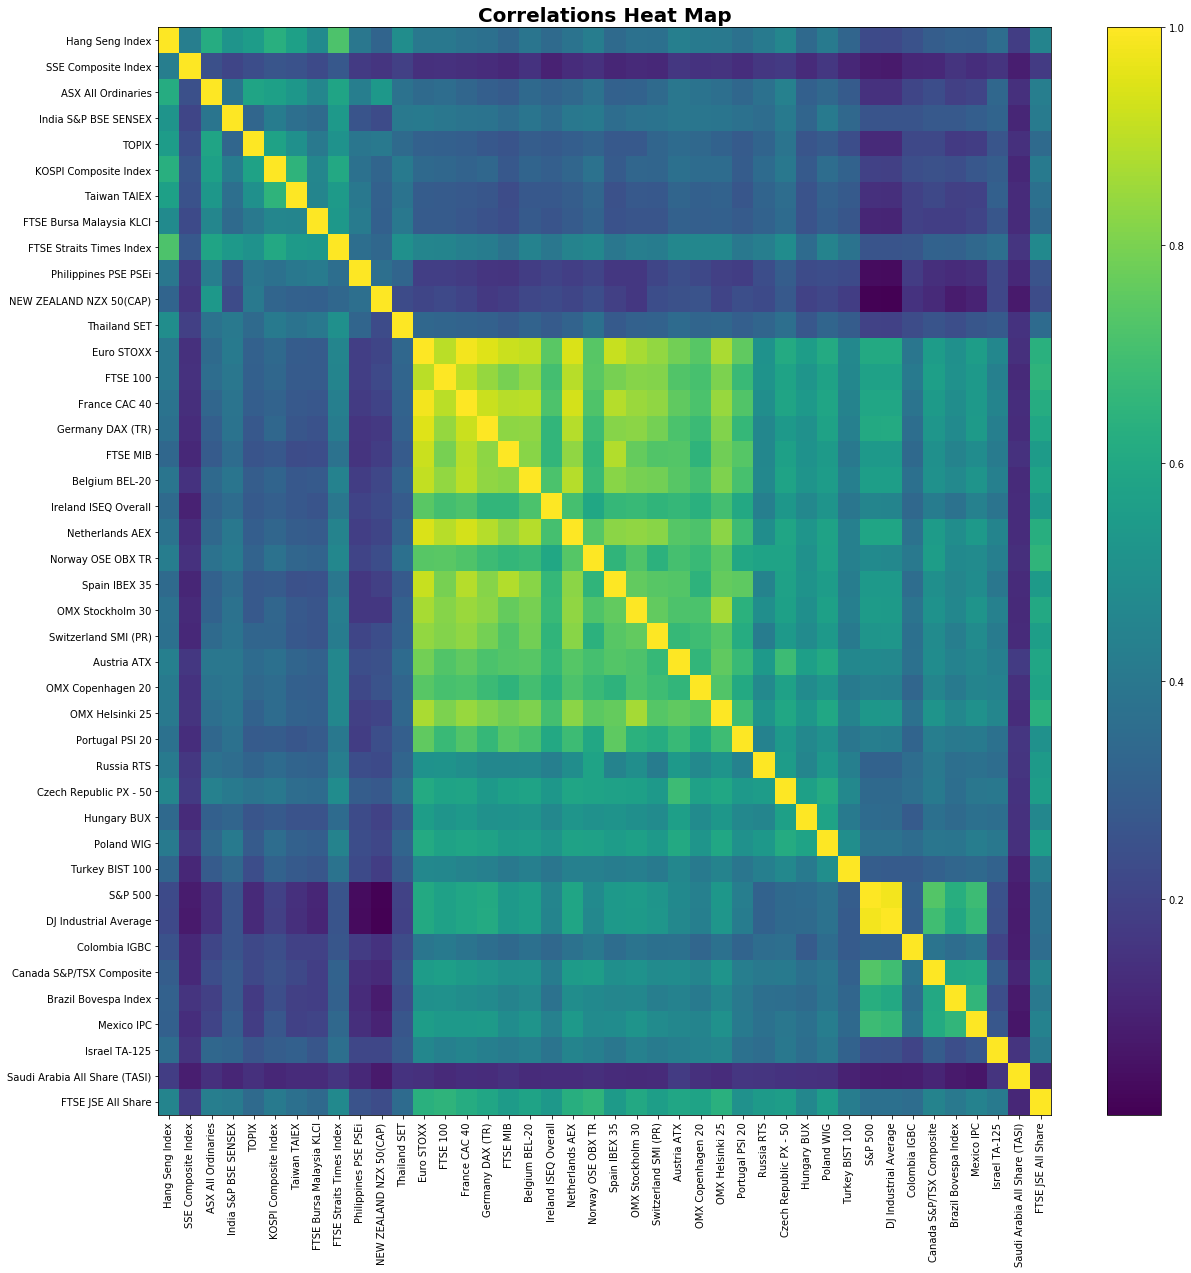

In [7]:
#Calculate correlation
corr = daily_ret.corr()

#Plot the correlation heatmap
plt.figure(figsize=(20,20))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlations Heat Map', fontsize=20, fontweight='bold')
plt.show()

### Splitting the data into Training set and test set

In [8]:
#Range of dates
print("Start Date:", dates[0])
print("End Date:", dates[len(dates)-1])
print("Total Number of dates:", len(dates))

Start Date: 20030305
End Date: 20170821
Total Number of dates: 3774


In [9]:
#Seperate the features and the labels
labels = lagged_data.iloc[:,0]
X = lagged_data.drop(daily_ret.columns[0], axis=1).reset_index(drop=True)

#Generate the labels from daily Hang Seng returns

#Set labels cutoff for defining Up/Down/Neutral states
labels_cutoff = 0.000627 #Try lower levels....0.05 seems a bit too high

y = np.empty(labels.shape)
y[labels < -labels_cutoff] = -1 #Label -1 for returns lower than -0.05%
y[labels > labels_cutoff] = 1 #Label 1 for returns greater than 0.05%
y[(labels <= labels_cutoff ) & (labels >= -labels_cutoff)] = 0 #Label 0 for the rest

In [10]:
#Import Keras module
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

#Import sklearn module
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [11]:
#Split into training set and test set
train_size = 0.9 #Again parameter to tune
val_size = 0.05

train_cut_index = int(np.floor(train_size * X.shape[0]))
val_cut_index = int(np.floor((train_size + val_size) * X.shape[0]))

X_train = np.array(X.iloc[0:(train_cut_index-1),:])
X_val = np.array(X.iloc[train_cut_index:(val_cut_index - 1),:])
X_test = np.array(X.iloc[val_cut_index:X.shape[0],:])

y_train = y[0:(train_cut_index-1)]
y_val = y[train_cut_index:val_cut_index-1]
y_test = y[val_cut_index:len(y)]

#Preproc the y_train and y_test using to_categorical function
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [12]:
#Prediction Period
print("Training Period Start:", dates[0])
print("Training Period End:", dates[train_cut_index-1])
print("Validation Period Start:", dates[train_cut_index])
print("Validation Period End:", dates[val_cut_index-1])
print("Test Period Start:", dates[val_cut_index])
print("Test Period End:", dates[len(dates)-1])
print("Number of data points in training set:", X_train.shape[0])
print("Number of data points in validation set:", X_val.shape[0])
print("Number of data points in test set:", X_test.shape[0])

Training Period Start: 20030305
Training Period End: 20160309
Validation Period Start: 20160310
Validation Period End: 20161129
Test Period Start: 20161130
Test Period End: 20170821
Number of data points in training set: 3395
Number of data points in validation set: 188
Number of data points in test set: 189


In [13]:
#Reshape data for inputting into LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
y_val = np.reshape(y_val, (y_val.shape[0], 1, y_val.shape[1]))
y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

In [14]:
#Evaluation metrics
from keras import backend as K

#Define f-beta score
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 0.6

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

#Define precision score
def precision(y_true, y_pred, threshold_shift=0):

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)

    precision = tp / (tp + fp)

    return precision

def hit_rate(y_true, y_pred):
    
    #Calculate Hit Rate of the prediction
    true_class = K.argmax(y_true, axis = -1)
    pred_class = K.argmax(y_pred, axis = -1)
    

In [15]:
#Print model evaluation metrics, takes in model scores from training and test set
def print_metrics(model_score):
    print("Test Loss:", model_score[0])
    print("Test F-beta:", model_score[1])
    print("Test Precision:", model_score[2])
    print("Test Accuracy:", model_score[3])

In [16]:
#Define plot metrics - can add more metrics towards it

def plot_metrics(model):
       
    #Plotting Loss over Epoch
    plt.figure(1)
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training','Validation'], loc='upper left')
    
    #Plotting F-beta over Epoch
    plt.figure(2)
    plt.plot(model.history['fbeta'])
    plt.plot(model.history['val_fbeta'])
    plt.title('F-Beta Score, beta=0.6')
    plt.ylabel('F-Beta Score')
    plt.xlabel('Epoch')
    plt.legend(['Training','Validation'], loc='upper left')
    
    #Plotting Precision over Epoch
    plt.figure(3)
    plt.plot(model.history['precision'])
    plt.plot(model.history['val_precision'])
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Training','Validation'], loc='upper left')
    
    #Plotting Hit Rate over Epoch
    plt.figure(4)
    plt.plot(model.history['acc'])
    plt.plot(model.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training','Validation'], loc='upper left')
    
    plt.show()

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix, without normalization'

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
#Utility function to return class numbers from probabilities
def prob_to_class(pred):
    return(np.argmax(pred, axis=-1))


In [19]:
#Setting base LSTM Network Parameters
drop_out = 0.6
input_shape = X_train.shape
num_epoch = 100
loss_fcn = 'categorical_crossentropy'
learning_rate = 0.0003
opt = optimizers.Nadam(lr=learning_rate)
num_of_perceptron = np.int(0.5 * (X_train.shape[2] + 3))

In [20]:
#Callbacks
saveModel = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True, mode='auto')
earlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', min_delta=0.0001)
callbacks = [saveModel, earlyStop]

## Q1. Fitting more data
Try to fit more data and see whether the performance will improve. Expectation is that fitting more data should be increase a bit of the model performance.

In [41]:
%%time
#Fit LSTM
from keras.layers import LSTM

#Setting up the instance
lstm_model = Sequential()

#Adding 1st LSTM layer
lstm_model.add(LSTM(num_of_perceptron, input_shape=input_shape[1:], return_sequences=True))
lstm_model.add(Dropout(drop_out))

#Adding Output Layer
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.summary()

#Optimization
#Define Optimizer, using Stochastic Gradient Decent
lstm_model.compile(loss=loss_fcn, optimizer=opt, metrics=[fbeta, precision, 'accuracy'])

#Fitting the model
lstm = lstm_model.fit(X_train, y_train, epochs = num_epoch, verbose=2, validation_data=(X_val, y_val), shuffle=False, batch_size=1, callbacks=callbacks)

#Evaluation
lstm_score = lstm_model.evaluate(X_test, y_test)

#Predict
lstm_pred = lstm_model.predict(X_test, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 22)             5632      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 22)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 3)              69        
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________
Train on 3395 samples, validate on 188 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.91145, saving model to weights.hdf5
8s - loss: 0.9675 - fbeta: 0.6758 - precision: 0.9943 - acc: 0.5240 - val_loss: 0.9115 - val_fbeta: 0.6897 - val_precision: 1.0000 - val_acc: 0.5904
Epoch 2/100
Epoch 00001: val_loss improved from 0.91145 to 0.88809, saving model to weights.hdf5
6s - loss: 0.9209 

Test Loss: 0.864687521306
Test F-beta: 0.761904762535
Test Precision: 0.931216936263
Test Accuracy: 0.640211642104


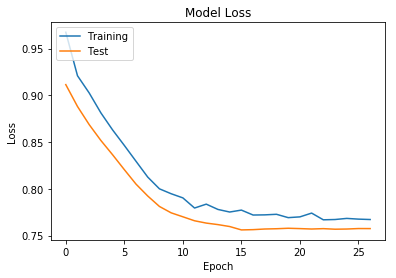

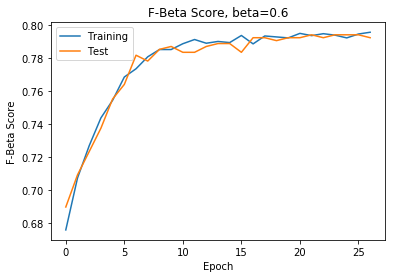

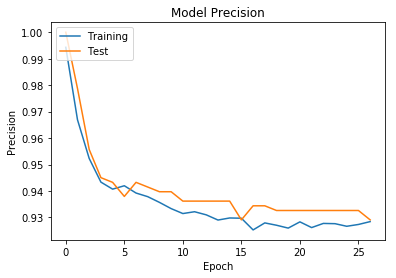

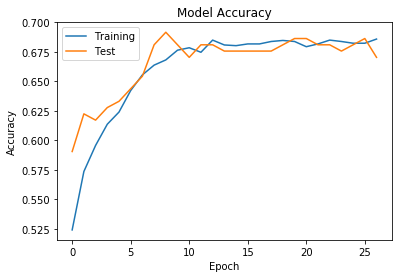

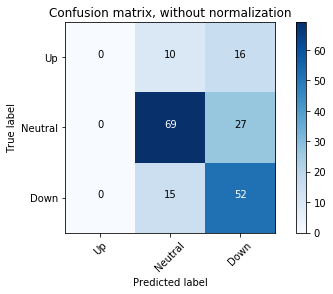

In [49]:
    print_metrics(lstm_score)
    
    plot_metrics(lstm)
    
    cfm = confusion_matrix(prob_to_class(y_test), prob_to_class(lstm_pred)) 
    plot_confusion_matrix(cfm, classes=['Up', 'Neutral', 'Down'], normalize=False)

There are 22 total Ups but we are not able to predict that. This will be an issue needs to be addressed. Model architect issue?


## Q2. Model Architecture
Things to tune:
- Number of perceptrons
- Layer
- Learning rate


### Adding an extra layer

In [51]:
%%time
#More Layers

#Setting up the instance
lstm_2 = Sequential()

#Adding 1st LSTM layer
lstm_2.add(LSTM(num_of_perceptron, input_shape=input_shape[1:], return_sequences=True))
lstm_2.add(Dropout(drop_out))

lstm_2.add(LSTM(np.int(num_of_perceptron/2), return_sequences=True))
lstm_2.add(Dropout(drop_out))

#Adding Output Layer
lstm_2.add(Dense(3, activation='softmax'))
lstm_2.summary()

#Optimization
#Define Optimizer, using Stochastic Gradient Decent
lstm_2.compile(loss=loss_fcn, optimizer=opt, metrics=[fbeta, precision, 'accuracy'])

#Fitting the model
lstm_2layer = lstm_2.fit(X_train, y_train, epochs = num_epoch, verbose=2, validation_data=(X_val, y_val), shuffle=False, batch_size=1, callbacks=[earlyStop])

#Evaluation
lstm_2_score = lstm_2.evaluate(X_test, y_test)

#Predict
lstm_2_pred = lstm_2.predict(X_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 22)             5632      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 22)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 11)             1496      
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 11)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 3)              36        
Total params: 7,164
Trainable params: 7,164
Non-trainable params: 0
_________________________________________________________________
Train on 3395 samples, validate on 188 samples
Epoch 1/100
12s - loss: 1.0026 - fbeta: 0.6664 - precision: 0.9959 - acc: 0.4642 - val_loss: 

9s - loss: 0.7791 - fbeta: 0.7955 - precision: 0.9312 - acc: 0.6863 - val_loss: 0.7584 - val_fbeta: 0.7943 - val_precision: 0.9309 - val_acc: 0.6596
Epoch 00045: early stopping
 32/189 [====>.........................] - ETA: 1sWall time: 7min 28s


Test Loss: 0.859829009841
Test F-beta: 0.758377418947
Test Precision: 0.931216934686
Test Accuracy: 0.656084657977


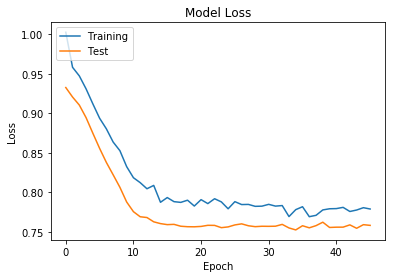

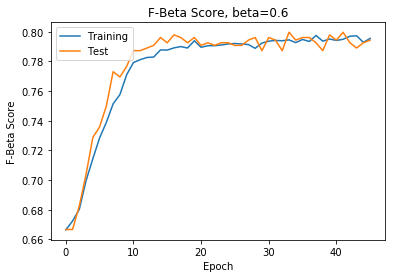

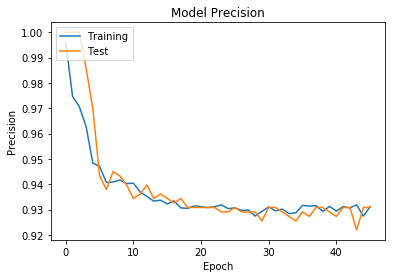

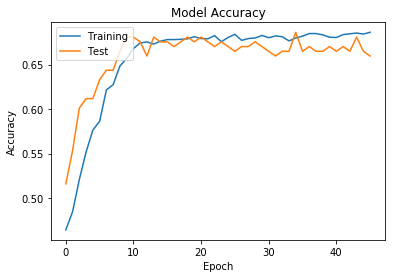

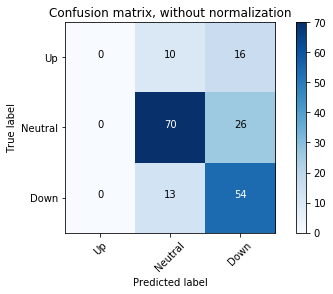

In [52]:
    print_metrics(lstm_2_score)
    
    plot_metrics(lstm_2layer)
    
    cfm2 = confusion_matrix(prob_to_class(y_test), prob_to_class(lstm_2_pred)) 
    plot_confusion_matrix(cfm2, classes=['Up', 'Neutral', 'Down'], normalize=False)

Not much difference..try number of 1 layer perceptrons.

### Look at different number of perceptrons

In [62]:
num_p = range(1,101) #Trying different number of percetrons
loss_p = np.zeros(len(num_p)) #Store test set model loss
acc_p = np.zeros(len(num_p)) #Store test set accuracry
pre_p = np.zeros(len(num_p)) #Store Precision

In [64]:
%%time

for p in num_p:

    #Setting up the instance
    model = Sequential()

    #Adding 1st LSTM layer
    model.add(LSTM(p, input_shape=input_shape[1:], return_sequences=True))
    model.add(Dropout(drop_out))

    #Adding Output Layer
    model.add(Dense(3, activation='softmax'))
    #lstm_model.summary()

    #Optimization
    #Define Optimizer, using Stochastic Gradient Decent
    model.compile(loss=loss_fcn, optimizer=opt, metrics=[fbeta, precision, 'accuracy'])

    #Fitting the model
    print("Training network with ", p, "hidden layers")
    temp = model.fit(X_train, y_train, epochs = num_epoch, verbose=0, validation_data=(X_val, y_val), shuffle=False, batch_size=1, callbacks=[earlyStop])

    #Evaluation
    score = model.evaluate(X_test, y_test)
    
    #Store the loss and accuracy
    loss_p[p-1] = score[0]
    pre_p[p-1] = score[2]
    acc_p[p-1] = score[3]


Training network with  1 hidden layers
Epoch 00039: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  2 hidden layers
Epoch 00026: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  3 hidden layers
Epoch 00026: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  4 hidden layers
Epoch 00034: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  5 hidden layers
Epoch 00037: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  6 hidden layers
Epoch 00030: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  7 hidden layers
Epoch 00037: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  8 hidden layers
Epoch 00024: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  9 hidden layers
Epoch 00040: early stoppi

 32/189 [====>.........................] - ETA: 0sTraining network with  71 hidden layers
Epoch 00019: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  72 hidden layers
Epoch 00029: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  73 hidden layers
Epoch 00022: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  74 hidden layers
Epoch 00030: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  75 hidden layers
Epoch 00034: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  76 hidden layers
Epoch 00015: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  77 hidden layers
Epoch 00024: early stopping
 32/189 [====>.........................] - ETA: 0sTraining network with  78 hidden layers
Epoch 00023: early stopping
 32/189 [====>.........................] - ETA: 0sTraini

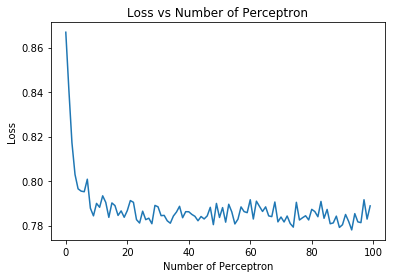

In [90]:
plt.plot(loss_p);
plt.title("Loss vs Number of Perceptron");
plt.ylabel("Loss");
plt.xlabel("Number of Perceptron");

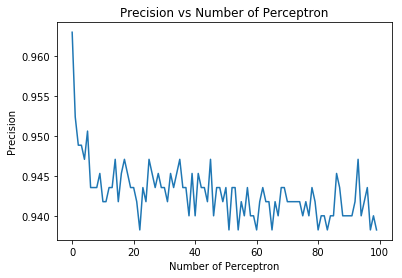

In [91]:
plt.plot(pre_p)
plt.title("Precision vs Number of Perceptron");
plt.ylabel("Precision");
plt.xlabel("Number of Perceptron");

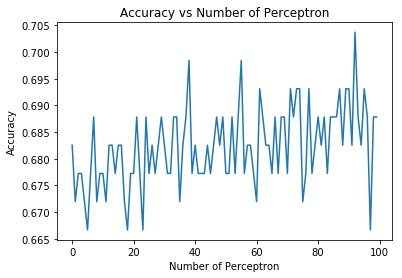

In [92]:
plt.plot(acc_p)
plt.title("Accuracy vs Number of Perceptron");
plt.ylabel("Accuracy");
plt.xlabel("Number of Perceptron");

In [95]:
%store pre_p
%store acc_p
%store loss_p

Stored 'pre_p' (ndarray)
Stored 'acc_p' (ndarray)
Stored 'loss_p' (ndarray)


As long as the number of perceptrons are not too high, it doesn't really affect too much on the model performance. SO we can stick to the 22 perceptrons and 1 hidden layer.

### Try Different Batch size?

In [111]:
batch = [1, 5, 10, 30]
loss_b = np.zeros(len(batch))
acc_b = np.zeros(len(batch))
pre_b = np.zeros(len(batch))

In [112]:
#Trying different batches

for i in range(0,len(batch)):
    batch_model = Sequential()

    #Adding 1st LSTM layer
    batch_model.add(LSTM(num_of_perceptron, input_shape=input_shape[1:], return_sequences=True))
    batch_model.add(Dropout(drop_out))

    #Adding Output Layer
    batch_model.add(Dense(3, activation='softmax'))
    batch_model.summary()

    #Optimization
    #Define Optimizer, using Stochastic Gradient Decent
    batch_model.compile(loss=loss_fcn, optimizer=opt, metrics=[fbeta, precision, 'accuracy'])

    #Fitting the model
    bm = batch_model.fit(X_train, y_train, epochs = num_epoch, verbose=1, validation_data=(X_val, y_val), shuffle=False, batch_size=batch[i], callbacks=[earlyStop])

    #Evaluation
    bm_score = batch_model.evaluate(X_test, y_test)

    #Predict
    bm_pred = batch_model.predict(X_test, verbose=1)
    
    loss_b[i] = bm_score[0]
    acc_b[i] = bm_score[3]
    pre_b[i] = bm_score[2]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 1, 22)             5632      
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 22)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 1, 3)              69        
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________
Train on 3396 samples, validate on 188 samples
Epoch 1/100
3396/3396 [==============================] - 10s - loss: 0.9503 - fbeta: 0.6916 - precision: 0.9900 - acc: 0.5642 - val_loss: 0.8688 - val_fbeta: 0.7216 - val_precision: 0.9911 - val_acc: 0.7340
Epoch 2/100
3396/3396 [==============================] - 8s - loss: 0.8832 - fbeta: 0.7418 - precision: 0.9561 - acc: 0.6216 - val_loss: 0.8117 - val_

3396/3396 [==============================] - 1s - loss: 0.7370 - fbeta: 0.8035 - precision: 0.9320 - acc: 0.6999 - val_loss: 0.7060 - val_fbeta: 0.8191 - val_precision: 0.9397 - val_acc: 0.7128
Epoch 35/100
3396/3396 [==============================] - 1s - loss: 0.7346 - fbeta: 0.8060 - precision: 0.9329 - acc: 0.7020 - val_loss: 0.7058 - val_fbeta: 0.8227 - val_precision: 0.9415 - val_acc: 0.7128
Epoch 36/100
3396/3396 [==============================] - 1s - loss: 0.7320 - fbeta: 0.8065 - precision: 0.9326 - acc: 0.6991 - val_loss: 0.7048 - val_fbeta: 0.8174 - val_precision: 0.9379 - val_acc: 0.7128
Epoch 37/100
3396/3396 [==============================] - 1s - loss: 0.7320 - fbeta: 0.8075 - precision: 0.9329 - acc: 0.7020 - val_loss: 0.7060 - val_fbeta: 0.8227 - val_precision: 0.9415 - val_acc: 0.7181
Epoch 38/100
3396/3396 [==============================] - 1s - loss: 0.7351 - fbeta: 0.8056 - precision: 0.9320 - acc: 0.7002 - val_loss: 0.7066 - val_fbeta: 0.8209 - val_precision: 0.9

3396/3396 [==============================] - 0s - loss: 0.7331 - fbeta: 0.8055 - precision: 0.9313 - acc: 0.6979 - val_loss: 0.7050 - val_fbeta: 0.8191 - val_precision: 0.9397 - val_acc: 0.7128
Epoch 55/100
3396/3396 [==============================] - 0s - loss: 0.7351 - fbeta: 0.8077 - precision: 0.9330 - acc: 0.7026 - val_loss: 0.7047 - val_fbeta: 0.8174 - val_precision: 0.9379 - val_acc: 0.7128
Epoch 56/100
3396/3396 [==============================] - 0s - loss: 0.7335 - fbeta: 0.8068 - precision: 0.9310 - acc: 0.7005 - val_loss: 0.7055 - val_fbeta: 0.8191 - val_precision: 0.9397 - val_acc: 0.7128
Epoch 57/100
3396/3396 [==============================] - 0s - loss: 0.7274 - fbeta: 0.8099 - precision: 0.9332 - acc: 0.7029 - val_loss: 0.7059 - val_fbeta: 0.8191 - val_precision: 0.9397 - val_acc: 0.7128
Epoch 58/100
3396/3396 [==============================] - 0s - loss: 0.7251 - fbeta: 0.8048 - precision: 0.9322 - acc: 0.7008 - val_loss: 0.7052 - val_fbeta: 0.8191 - val_precision: 0.9

Train on 3396 samples, validate on 188 samples
Epoch 1/100
3396/3396 [==============================] - 2s - loss: 1.0304 - fbeta: 0.6670 - precision: 0.9999 - acc: 0.5539 - val_loss: 0.9648 - val_fbeta: 0.6667 - val_precision: 1.0000 - val_acc: 0.6649
Epoch 2/100
3396/3396 [==============================] - 0s - loss: 0.9524 - fbeta: 0.6831 - precision: 0.9963 - acc: 0.5780 - val_loss: 0.9067 - val_fbeta: 0.6791 - val_precision: 0.9982 - val_acc: 0.6862
Epoch 3/100
3396/3396 [==============================] - 0s - loss: 0.9213 - fbeta: 0.7046 - precision: 0.9797 - acc: 0.5892 - val_loss: 0.8766 - val_fbeta: 0.7163 - val_precision: 0.9982 - val_acc: 0.7074
Epoch 4/100
3396/3396 [==============================] - 0s - loss: 0.9019 - fbeta: 0.7225 - precision: 0.9653 - acc: 0.6001 - val_loss: 0.8565 - val_fbeta: 0.7482 - val_precision: 0.9876 - val_acc: 0.7234
Epoch 5/100
3396/3396 [==============================] - 0s - loss: 0.8948 - fbeta: 0.7321 - precision: 0.9576 - acc: 0.6087 - va

3396/3396 [==============================] - 0s - loss: 0.7328 - fbeta: 0.8080 - precision: 0.9342 - acc: 0.7061 - val_loss: 0.7082 - val_fbeta: 0.8209 - val_precision: 0.9415 - val_acc: 0.7021
Epoch 80/100
3396/3396 [==============================] - 0s - loss: 0.7372 - fbeta: 0.8035 - precision: 0.9329 - acc: 0.7002 - val_loss: 0.7082 - val_fbeta: 0.8191 - val_precision: 0.9415 - val_acc: 0.7021
Epoch 81/100
3396/3396 [==============================] - 0s - loss: 0.7379 - fbeta: 0.8058 - precision: 0.9328 - acc: 0.6979 - val_loss: 0.7069 - val_fbeta: 0.8174 - val_precision: 0.9397 - val_acc: 0.7074
Epoch 82/100
3396/3396 [==============================] - 0s - loss: 0.7307 - fbeta: 0.8070 - precision: 0.9331 - acc: 0.7014 - val_loss: 0.7071 - val_fbeta: 0.8191 - val_precision: 0.9415 - val_acc: 0.7074
Epoch 83/100
3396/3396 [==============================] - 0s - loss: 0.7316 - fbeta: 0.8050 - precision: 0.9310 - acc: 0.6994 - val_loss: 0.7067 - val_fbeta: 0.8174 - val_precision: 0.9

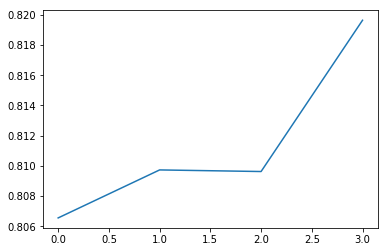

In [121]:
plt.plot(loss_b)


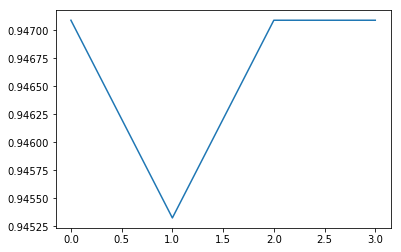

In [123]:
plt.plot(pre_b)

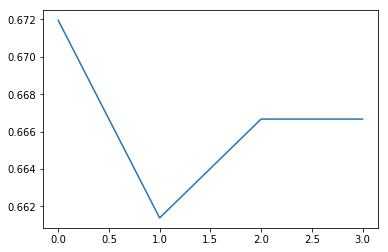

In [124]:
plt.plot(acc_b)

Predicting 1-day forward seems the best

### Adding High, Low Levels

In [31]:
#Load the index data
raw_data2 = pd.read_csv('index_data_aug.csv', skiprows=1)
raw_data2.set_index(['Date'])

#Relabeling the data
#relabeling the index data
index_price = raw_data2.iloc[:,1:]
dates2 = raw_data2.iloc[:,0]

#Dimensions
print("Number of data points:", index_price.shape[0])
print("Number of indices:", index_price.shape[1])

#Preprocess and transform to log-returns
#Calculate log returns.
daily_ret2 = np.log(index_price/index_price.shift(1))

#Remove first row
daily_ret2 = daily_ret2.drop(daily_ret2.index[0]).reset_index(drop=True)
dates2 = dates2.drop(dates2.index[0]).reset_index(drop=True)

daily_ret2.head()

Number of data points: 3780
Number of indices: 126


,Hang Seng Index,SSE Composite Index,ASX All Ordinaries,India S&P BSE SENSEX,TOPIX,KOSPI Composite Index,Taiwan TAIEX,FTSE Bursa Malaysia KLCI,FTSE Straits Times Index,Philippines PSE PSEi,...,Turkey BIST 100 Low,S&P 500 Low,DJ Industrial Average Low,Colombia IGBC Low,Canada S&P/TSX Composite Low,Brazil Bovespa Index Low,Mexico IPC Low,Israel TA-125 Low,Saudi Arabia All Share (TASI) Low,FTSE JSE All Share Low
0,-0.009418,-0.000773,-0.001649,-0.009957,0.002927,-0.023076,-0.005982,0.000000,-0.009960,0.001405,...,-0.017117,-0.013018,-0.015253,0.002738,-0.007786,0.000000,-0.004705,-0.002892,0.002138,-0.012712
1,-0.007950,-0.004685,-0.013474,-0.005780,-0.006348,-0.028713,-0.018297,-0.009518,-0.003166,-0.016025,...,0.042715,-0.003424,-0.005596,-0.001384,-0.005067,-0.004737,0.002771,-0.010173,-0.003399,-0.015361
2,-0.016260,-0.012493,-0.000982,-0.011143,-0.008041,-0.008838,-0.004689,-0.000996,-0.018028,0.005964,...,0.014997,0.000976,-0.000291,0.004466,-0.009635,0.020215,-0.002628,0.013825,0.001135,-0.006911
3,-0.006174,-0.003510,-0.011717,-0.011757,-0.024871,-0.016907,-0.010711,-0.010594,-0.016729,-0.000916,...,0.002468,-0.010556,-0.012672,0.003005,0.004927,0.012327,-0.002627,0.000000,0.000000,-0.019950
4,-0.005091,-0.016323,-0.001437,-0.008658,-0.014741,-0.003265,-0.007058,-0.017264,-0.011979,-0.004039,...,0.018509,-0.005847,-0.000398,-0.001806,-0.013007,-0.013914,-0.003113,-0.012932,-0.023851,-0.015221


In [32]:
#Seperate the indices into 2 classes - lag or no_lag
no_lag2 = [0, 1, 2, 4, 5, 6, 9, 10, 42, 43, 44, 46, 49, 50, 51, 84, 85, 86, 88, 89, 90, 92, 93]
lag2 = [i for i in range(0,daily_ret2.shape[1]) if i not in no_lag2]

#Processing the dataset by applying appropriate lags
lagged_data2 = daily_ret2.iloc[:,lag2].shift(1)
lagged_data2 = pd.concat([daily_ret2.iloc[:,no_lag2], lagged_data2], axis=1)

#Removing the first row
lagged_data2 = lagged_data2.drop(lagged_data2.index[0]).reset_index(drop=True)
dates2 = dates2.drop(dates2.index[0]).reset_index(drop=True)

In [33]:
labels2 = lagged_data2.iloc[:,0]
y2 = np.empty(labels2.shape)
y2[labels2 < -labels_cutoff] = -1 #Label -1 for returns lower than -0.05%
y2[labels2 > labels_cutoff] = 1 #Label 1 for returns greater than 0.05%
y2[(labels2 <= labels_cutoff ) & (labels2 >= -labels_cutoff)] = 0 #Label 0 for the rest



X2 = lagged_data2.drop(lagged_data2.columns[0], axis=1).reset_index(drop=True)

train_cut_index2 = int(np.floor(train_size * X2.shape[0]))
val_cut_index2 = int(np.floor((train_size + val_size) * X2.shape[0]))

X2_train = np.array(X2.iloc[0:(train_cut_index2-1),:])
X2_val = np.array(X2.iloc[train_cut_index2:(val_cut_index2 - 1),:])
X2_test = np.array(X2.iloc[val_cut_index2:X2.shape[0],:])

y_train2 = y2[0:(train_cut_index2-1)]
y_val2 = y2[train_cut_index2:val_cut_index2-1]
y_test2 = y2[val_cut_index2:len(y2)]

#Preproc the y_train and y_test using to_categorical function
y_train2 = to_categorical(y_train2, num_classes=3)
y_val2 = to_categorical(y_val2, num_classes=3)
y_test2 = to_categorical(y_test2, num_classes=3)

In [34]:
#Reshape data for inputting into LSTM
X2_train = np.reshape(X2_train, (X2_train.shape[0], 1, X2_train.shape[1]))
X2_val = np.reshape(X2_val, (X2_val.shape[0], 1, X2_val.shape[1]))
X2_test = np.reshape(X2_test, (X2_test.shape[0], 1, X2_test.shape[1]))

y_train2 = np.reshape(y_train2, (y_train2.shape[0], 1, y_train2.shape[1]))
y_val2 = np.reshape(y_val2, (y_val2.shape[0], 1, y_val2.shape[1]))
y_test2 = np.reshape(y_test2, (y_test2.shape[0], 1, y_test2.shape[1]))

In [35]:
print(X2_test.shape)
print(X2.shape)
print(y_test2.shape)
print(lagged_data2.shape)

(189, 1, 125)
(3778, 125)
(189, 1, 3)
(3778, 126)


In [38]:
%%time
#Fit LSTM
from keras.layers import LSTM
num_of_perceptron2 = np.int(0.5 * (X2_train.shape[2] + 3))

#Setting up the instance
model3 = Sequential()

#Adding 1st LSTM layer
model3.add(LSTM(num_of_perceptron2, input_shape=X2_train.shape[1:], return_sequences=True))
model3.add(Dropout(drop_out))

#Adding Output Layer
model3.add(Dense(3, activation='softmax'))
model3.summary()

#Optimization
#Define Optimizer, using Stochastic Gradient Decent
model3.compile(loss=loss_fcn, optimizer=opt, metrics=[fbeta, precision, 'accuracy'])

#Fitting the model
m3 = model3.fit(X2_train, y_train2, epochs = num_epoch, verbose=2, validation_data=(X2_val, y_val2), shuffle=False, batch_size=1, callbacks=[earlyStop])

#Evaluation
m3_score = model3.evaluate(X2_test, y_test2)

#Predict
m3_pred = model3.predict(X2_test, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 64)             48640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 3)              195       
Total params: 48,835
Trainable params: 48,835
Non-trainable params: 0
_________________________________________________________________
Train on 3399 samples, validate on 188 samples
Epoch 1/100
10s - loss: 0.9535 - fbeta: 0.7008 - precision: 0.9829 - acc: 0.5781 - val_loss: 0.8559 - val_fbeta: 0.7411 - val_precision: 0.9716 - val_acc: 0.6596
Epoch 2/100
9s - loss: 0.8430 - fbeta: 0.7708 - precision: 0.9476 - acc: 0.6614 - val_loss: 0.7898 - val_fbeta: 0.7819 - val_precision: 0.9504 - val_acc: 0.7128
Epoch 3/100
8s - loss: 0.7881 - 

 32/189 [====>.........................] - ETA: 0sWall time: 6min 41s


Test Loss: 0.691810366023
Test F-beta: 0.818342151781
Test Precision: 0.943562609178
Test Accuracy: 0.714285712709


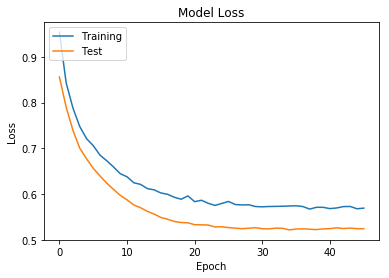

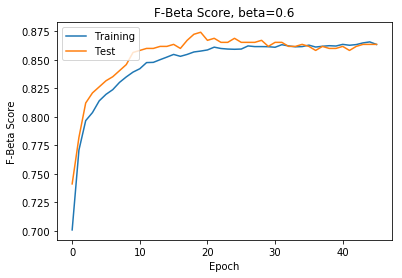

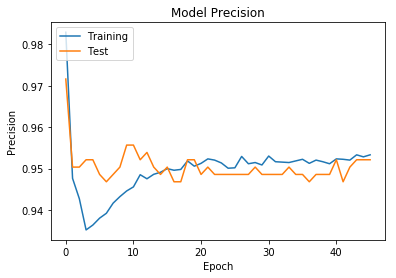

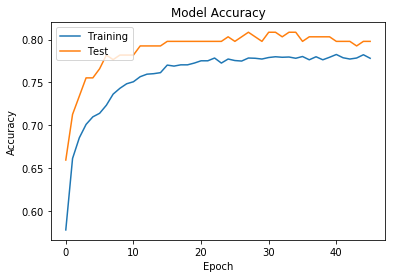

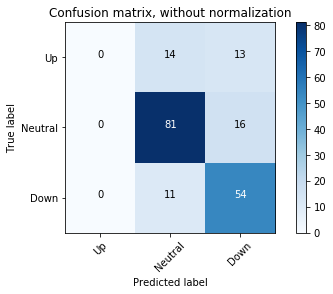

In [39]:
print_metrics(m3_score)  
plot_metrics(m3)
cfm3 = confusion_matrix(prob_to_class(y_test2), prob_to_class(m3_pred)) 
plot_confusion_matrix(cfm3, classes=['Up', 'Neutral', 'Down'], normalize=False)


In [40]:
m3_score = model3.evaluate(X2_test, y_test2)

 32/189 [====>.........................] - ETA: 0s